# Notes on Numerical Radiative Transfer
### Javier Garcia & Ekaterina Sokolova-Lapa --- July 2018

These are some notes on the numerical methods to solve the radiative transfer problem, specifically using the Feautrier method. Calculations are done with the routines in the XILLVER code, and compare with the new routines by Sokolova-Lapa, and benchmarked against analytic and semi-analytic solutions in simple limiting cases.



In [1]:
%matplotlib inline

import matplotlib
import pylab
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits as pyfits
from astropy.io import ascii
import const as c
import sl_nored as fnr
import sl_red as fr

# One-angle solution for a pure scattering atmopshere

Start with the symmetric average 

$u_{E,\tau,\mu} = 1/2 ( I^+_{E,\tau,\mu} + I^-_{E,\tau,\mu})$

one can write the transfer equation as a second-order differential equation

$\mu^2 \frac{\partial^2 u_{E,\tau,\mu}}{\partial\tau^2_{E}} = u_{E,\tau,\mu} - S_{E,\tau}$

From now on, I will drop the obvious dependence on the optical depth $\tau$

The source function is

$S_{E,\tau} = \frac{\alpha_s J_E}{\chi_E} + \frac{j_E}{\chi_E}$

where $\chi_E = \alpha_s + \alpha_a$ is the total opacity, and $\alpha_s = n_e\sigma_T$ and $\alpha_a = n_e\sigma_a$ are the scattering and absorption coefficients, respectively, with $n_e$ being the electron density and $\sigma_T = 6.65\times 10^{-25}$ cm$^2$ is the Thomson cross section, and $\sigma_a$ is the total due to absorption (bound-bound, bound-free, free-free, etc.)

Assuming a pure isotropic scattering atmosphere

$S_E = J_E$

and in the one angle limit

$J_E = \int_0^1{u_{E,\mu} d\mu}$

$J_E = u_E$

Then the transfer equation becomes

$\mu^2 \frac{\partial^2 u_{E,\mu}}{\partial\tau^2_{E}} = 0$

Which solution is 

$u_{E,\tau} = C_1 + C_2 \tau$

The constants are found by setting the boundary conditions. At the top ($\tau=0$) we set $I^- = I_{inc}$. At the bottom of the slab ($\tau=\tau_{max}$), we set $I^+ = I_{bb}$

The final solution thus is

$u_{E,\tau} = \left( \frac{I_{bb} - I_{inc}}{\tau_{max} + 2\mu}\right)
\left[ \tau - (\tau_{max} + \mu)\right] + I_{bb}$

At the surface, $u_{E,\mu} = 1/2(I^+_{E,\mu} + I_{inc})$ and

$I^+_{E,\mu} = I_{inc} \left[ \frac{\tau_{max}}{\tau_{max}+2\mu}\right]
+ I_{bb} \left[\frac{2\mu}{\tau_{max}+2\mu} \right]$

This is the reflected intensity at the top of the slab. We can now use this expression to check the numerical solution in the limit of one angle (typically $\mu=0.5$) for the pure-scattering case. 

Interestingly, as $\tau_{max}$ grows, the left-hand side of the solution approaches to $\approx I_{inc}$, meaning that in the limit of a semi-infinite slab, the observer should see all the incident radiation reflected back. Conversely, at small $\tau_{max}$ some of the incident radiation is transmitted throughout the bottom of the slab. Meanwhile, the right-hand side of the solution behaves as $\approx I_{bb}/\tau_{max}$, thus, the larger $\tau_{max}$ the more attenuation the observer will see in the field coming from the bottom.

In [2]:
# Black body
def bbint(homega, kt):
    """Black body spectra
    
    returns the intensity in erg / s / cm^2 / strd / Hz
    """
    I_bb = np.zeros((homega.size))
    for ni in range(I_bb.size):
        if homega[ni] / kt < 0.01:
            I_bb[ni] = 2. * kt * (homega[ni]/(c.herg*c.cl))**2
        elif homega[ni] / kt > 10.:
            I_bb[ni] = 2. * homega[ni]**3 / (c.herg*c.cl)**2 * np.exp(-homega[ni]/kt) 
        else:
            I_bb[ni] = 2. * homega[ni]**3 / (c.herg*c.cl)**2 /(np.exp(homega[ni]/kt) - 1.)
    return I_bb

# power law:
def powint(gamma, homega, I_bb):
    """Power law spectra
    
    returns the intensity in erg / s / cm^2 / strd / Hz
    """
    F_bb = np.trapz(I_bb, homega / c.herg)
    I_inc_nn = (homega / c.herg)**(-(gamma - 1.))
    F_inc_nn = np.trapz(I_inc_nn, homega / c.herg)
#    f = F_bb * 1e-10
    # I estimated that my PL is ~8.5 higher (because of the low E cutoff)
    f = F_bb * 1e-10 * 8.5 
    I_inc = f * (homega / c.herg)**(-(gamma - 1)) / F_inc_nn
    return I_inc

def iplus_oneang(mu, tau_max, I_inc, I_bb):
    I_plus = I_inc * (tau_max / (tau_max + 2.*mu)) + I_bb * (2.*mu / (tau_max + 2.*mu))
    return I_plus
    

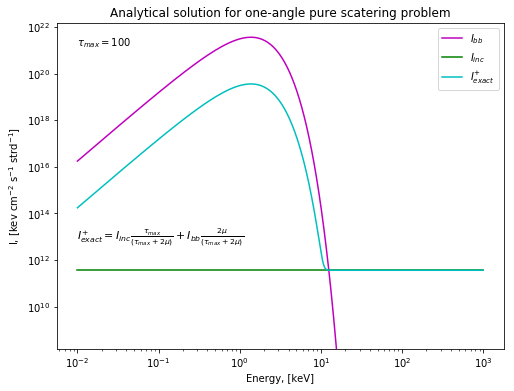

In [11]:
# frequency grid:
Nn = 500
homega = np.logspace(-2., 3., Nn) * c.keverg

# parameters:
kt = 0.35 * c.keverg
tau_max = 100.
mu = 0.5

# boundary conditions:
I_bb = bbint(homega, kt)
I_inc = powint(2, homega, I_bb)

# I^{\plus}:
I_plus_an = iplus_oneang(mu, tau_max, I_inc, I_bb)

plt.loglog(homega / c.keverg, I_bb / c.hkev * c.ergkev * homega, color='m', label=r'$I_{bb}$')
plt.loglog(homega / c.keverg, I_inc / c.hkev * c.ergkev * homega, color='g', label=r'$I_{inc}$')
plt.loglog(homega / c.keverg, I_plus_an / c.hkev * c.ergkev * homega, color='c', label=r'$I^{\plus}_{exact}$')
plt.xlabel(r'Energy, [keV]')
plt.ylabel(r'I, [kev cm$^{-2}$ s$^{-1}$ strd$^{-1}$]')
plt.text(0.01, 1.5e+21, r'$\tau_{max} = %d $' % tau_max)
plt.text(0.01, 0.75e+13, r'$I^{\plus}_{exact} = \
         I_{inc}\frac{\tau_{max}}{(\tau_{max} + 2\mu)} + \
         I_{bb}\frac{2\mu}{(\tau_{max}+2\mu)}$', fontsize=11)
plt.ylim(1.5e+8, 1.5e+22)
plt.title('Analytical solution for one-angle pure scatering problem')
plt.legend()
plt.show()

### The radiative transfer solution by  XILLVER (v 2.3.1) ###

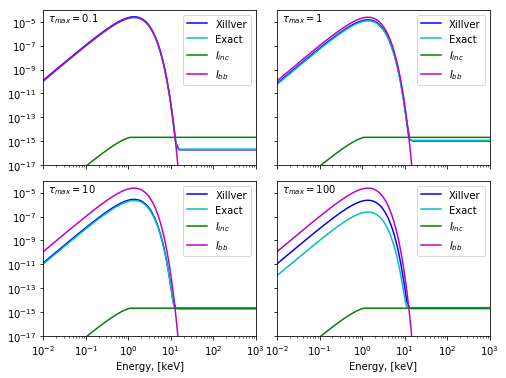

In [12]:
# Read the output from XILLVER (v 2.3.1) runs

tau_max_arr = np.array([0.1, 1., 10., 100.])
tau_max_str = ['0.1', '1', '10', '100']

matplotlib.rcParams['figure.figsize'] = (8, 6)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, sharey=True, gridspec_kw={'wspace': 0.1, 'hspace': 0.1})
ax = [ax1, ax2, ax3, ax4]

for ti in range(tau_max_arr.size):
    I_plus = iplus_oneang(mu, tau_max_arr[ti], I_inc, I_bb)
    xill_path='./xillver_outputs_nored/current_tau_' + tau_max_str[ti] + '/'
    xill_int = ascii.read(xill_path+'intensity')
    xill_flux = ascii.read(xill_path+'spectr')
    
    ener = np.array(xill_int[0][:]/1.e3) # Energies in keV
    inte = np.array(xill_int[1][:])      # Intensities in erg/cm^2/s/str/erg (I think!)
    flux = np.array(xill_flux[1][:])     # Angle-averaged fluxes (erg/cm^2/s/erg)
    finc = np.array(xill_flux[5][:])     # Incident flux (erg/cm^2/s/erg)
    
    ergsev = 1.602197e-12
    
    ax[ti].text(0.013, 1e-5, r'$\tau_{max} = $' + tau_max_str[ti])

    ax[ti].loglog(ener, inte*ener*ergsev**3., color='b', label=r'Xillver')
    ax[ti].loglog(homega / c.keverg, I_plus * homega, color='c', label=r'Exact')
    ax[ti].loglog(ener, finc*ener*ergsev**3.*2./0.5, color='g', label=r'$I_{inc}$')
    ax[ti].loglog(homega / c.keverg, I_bb * homega, color='m', label=r'$I_{bb}$')

    ax[ti].legend()
    ax[ti].set_xlim(1e-2, 1e3)
    ax[ti].set_ylim(1e-17, 1e-4)
    
    if ti == 0 or ti == 1:
        ax[ti].set_xticklabels([])
        
    else:
        ax[ti].set_xlabel(r'Energy, [keV]')
    
plt.show()
    

<b>NOTE (Katya):</b> the output from Xillver for $\tau=100$ is the same as from $\tau=10$, I'd guess it was just calculated for the same optical depth ($\tau=10$). Could you please run the calculation again for the optical depth $\tau=100$? 
If I read from '.../current_tau_100_KN' then result is correct.

Important Notes:

- I have to multiply $F_{inc}$ by $2/\mu$ in order to convert from flux to intensity (xillver).
- To compare with the exact solution, I am multiplying the xillver spectra by ergsev^3 (conversion from erg to eV). I think this is correct because my intensities are in ergs/cm^2/s/erg; plus one more energy dimension due to the $E*F_E$. But we should check carefully the units. 

The agreement with the exact solution is very good, specially in the Black-body region, which iis attenuated by $1/\tau_{max}$. Howeber, XILLVER still have a small decrease at high energies. This decrease is fixed if more than one angle is used in the Feautrier solution (not sure why the numerical solution will not give a better agreement with the exact solution for one angle, or why the one-angle solution looks very much like the multi-angle one).

Below are more comparisons for different values of $\tau_{max}$.

The behavior for different $\tau_{max}$ is correct, but I do not understand why the discrepancy at high energies becomes worse for small $\tau_{max}$. 
(Solved: Klein-Nishina cross section was used)

To Do:

- Compare the multi-angle solution with Chandrasekar's
- Include Compton redistribution and compare with Katya's result
- Compare the execution times of both codes



### The radiative transfer solution by Sokolova-Lapa's routies:###

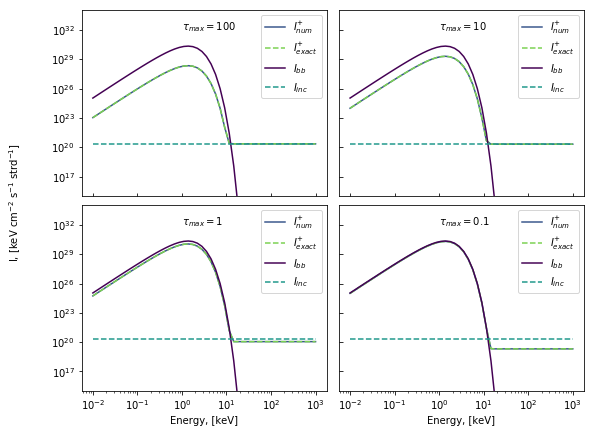

In [29]:
# parameters:
tau_max_arr = np.array([100., 10., 1., 0.1])
Mn = 1
mi_0 = 0
Nn = 50
homegakev = np.logspace(-2., 3., Nn)
homega = homegakev * c.keverg
Dn = 100
kT_BB = 0.35 * c.keverg
I_bb = bbint(homega, kT_BB)
I_inc = powint(2, homega, I_bb)
bottom = 1


# calculating the solution for the set of tau_max:
u0_arr = []
tau_depth_arr = []
for tau_max in tau_max_arr:
    tau_depth, mu, u =  fnr.radtransf(tau_max, Dn, Mn, mi_0, homega, I_inc, kT_BB, bottom)
    u0_arr.append(u[0])
    tau_depth_arr.append(tau_depth)
    
    
# plotting:
matplotlib.rcParams['figure.figsize'] = (9, 7)
    
colors = plt.cm.viridis(np.linspace(0.0, 0.8, 4))

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, sharey=True, gridspec_kw={'wspace': 0.05, 'hspace': 0.05})
ax = [ax1, ax2, ax3, ax4]

for ti in range(tau_max_arr.size):
    u0 = u0_arr[ti]
    #uz = u[0]
    I_plus = np.zeros((Nn))
    for ni in range(Nn):
        un = u0[ni]
        for mi in range(Mn):
            if mi == mi_0:
                I_plus[ni] = (2.*un[mi] - I_inc[ni])
    I_plus_an = I_inc*(tau_max_arr[ti]/(tau_max_arr[ti] + 2.*mu[0])) + I_bb*(2.*mu[0] / (tau_max_arr[ti] + 2.*mu[0]))
    ax[ti].loglog(homegakev, I_plus/c.hkev*c.ergkev*homegakev, color=colors[1], linewidth = 1.5, label=r'$I^{\plus}_{num}$')
    ax[ti].loglog(homegakev, I_plus_an/c.hkev*c.ergkev*homegakev, color=colors[3], linestyle='--', linewidth = 1.5, label=r'$I_{exact}^{\plus}$')
    ax[ti].loglog(homegakev, I_bb/c.hkev*c.ergkev*homegakev, color=colors[0], linewidth = 1.5, label=r'$I_{bb}$')
    ax[ti].loglog(homegakev, I_inc/c.hkev*c.ergkev*homegakev, color=colors[2], linestyle='--', linewidth = 1.5, label=r'$I_{inc}$')
    #if ti == 0 or ti == 2:
    #    #ax[ti].set_ylabel(r'$I$, [keV cm$^{-2}$ s$^{-1}$ strd$^{-1}$]')
    #else:
    #    ax[ti].set_yticks([])
    if ti == 0 or ti == 1:
        ax[ti].set_xticklabels([])
        ax[ti].minorticks_off()
        ax[ti].tick_params(axis='x', direction='in')
    else:
        ax[ti].set_xlabel(r'Energy, [keV]')
    if ti == 1 or ti == 3:
        ax[ti].tick_params(axis='y', direction='in')
    #ax[ti].tick_params(direction='in')
    ax[ti].set_ylim(1e+15, 1e+34)
    ax[ti].legend()#(fontsize='small')#, labelspacing=0.5)
    if ti == 3:
        ax[ti].text(1., 1e+32, r'$\tau_{max} = %.1f $' % tau_max_arr[ti], fontsize=10)
    else:
        ax[ti].text(1., 1e+32, r'$\tau_{max} = %d $' % tau_max_arr[ti], fontsize=10)
#ax1.set_ylabel(r'$I$, [keV cm$^{-2}$ s$^{-1}$ strd$^{-1}$]')
fig.text(0.01, 0.5, r'I, [keV cm$^{-2}$ s$^{-1}$ strd$^{-1}$]', va='center', rotation='vertical')
plt.savefig("oneang_alltau.pdf", dpi='figure')
plt.show()

The results of both calculations - XILLVER and Sokolova-Lapa's routines - match with the exact solution for the radiation propagating at one angle in the pure scattering atmosphere.

# The Chandrasekhar solution

Complicating the task, one can suggest to include the angular distribution. For this case the analytical solution of the radiative transfer equation: 

$$\mu\frac{dI(\tau,\mu)}{d\tau}=I(\tau,\mu) - S(\tau,\mu)$$

was obtained by Chandrasekhar (1960, Chapter 3) for isotropic scattering in the plane-parallel semi-infinite atmosphere illuminated by the incident flux at the certain angle $\mu_{0}$. The source function can be written:

$$S(\tau, \mu) = \frac{1}{2}\int^{+1}_{-1}I(\tau,\mu^{'})d\mu^{'} - \frac{1}{4}\omega_{0} F e^{-\tau/\mu_{0}}\ ,$$ 

where $\omega_{0}$ is a single scattering albedo which for pure scattering case: $\omega_{0}=1$.
 
The solution for the intensity can be written with the help of Chandrasekhar's H-functions $H(\mu)$ defined in the interval $0 \leq \mu \leq 1$ and for isotropic scattering satisfes the following integral equation:

$$H(\mu) = 1 + \frac{\omega_{0}}{2}\mu H(\mu) \int^{1}_{0}\frac{H(\mu^{'})}{\mu+\mu^{'}}d\mu^{'}.$$

The final expression for the reflected intensity is

$$I(0, \mu)=\frac{F}{4}\frac{\mu_{0}}{\mu + \mu_{0}}H(\mu)H(\mu_{0})\ . $$


The same as before, we want to obtain the numerical solution of the radiative transfer using the Feautier method and represent it in the form

$$\mu^2 \frac{\partial^2 u_{E,\tau,\mu}}{\partial\tau^2_{E}} = u_{E,\tau,\mu} - S_{E,\tau} \ ,$$

with the following boundary conditions for the top and bottom of the 
atmosphere, respectively:

$$\mu\frac{du_{E, \tau,\mu}}{d\tau} \bigg |_{\tau=0} = -\frac{1}{2}I^{+}_{E,\mu}$$

$$\frac{du_{E, \tau,\mu}}{d\tau} \bigg |_{\tau=\tau_{\mathrm{max}}} = 0.$$


### Remarks on bottom boundary conditions:

There are two general types of the bottom boundary conditions which are used to model the atmosphere. 
The one presented above: $du(\tau=\tau_{\mathrm{max}})/d\tau = 0$ describes the well-known diffusion limit when the energy transfer process is represented as the photon diffusion in the medium. Usually, this approach is applicable when the field differs little from the equilibrium and the mean free path of a photon is much smaller than the characteristic size of the problem. This boundary condition is appropriate for the task with the large optical depths when atmosphere can be treated as semi-infinite. It implies that the antisymmetric average (flux-like) is equal to zero 

$$\frac{(I^{+}(\tau=\tau_{\mathrm{max}}) - I^{-}(\tau=\tau_{\mathrm{max}}))}{2} = 0$$ 

hence the intensities of outgoing and incoming radiation through the boundary are equal which is an analog of the mirror at the bottom of the atmosphere. This boundary condition is also sometimes referred to as a 'reflecting' one.

In the bottom of the thinner atmospheres diffusion limit violates and one has to consider, for example, the illumination by seed photons with some spectral distribution $I^{+}$. The boundary condition can be written as

$$\mu\frac{du_{E, \tau=\tau_{\mathrm{max}},\mu}}{d\tau} = u_{E, \tau=\tau_{\mathrm{max}},\mu} - I^{+} \ .$$

Important to note the second boundary condition doesn't turn into the diffusion one just assuming that there's no flux illuminating the atmosphere from below, i.e $I^{+}=0$. The illustration of this statement you can see from two different results calculated for the multi-angle pure scattering problem, when for the second boundary condition the correct solution is only obtained by setting large optical depths of the atmosphere.

In [4]:
# Chandrasekhar's analytical solution for 

def chand_multiang(I_inc, homega, mu, mi_0):
    """
    Analytical solution by Chandrasekhar (1960, Chapter 3)
    for multi-angle radiative transfer in plane-parallel semi-infinite 
    atmosphere with the pure isotropic scattering. Atmosphere 
    is illuminated under angle 'mu_0 = mu[mi_0]' by I_inc.
    """
    mu_0 = mu[mi_0]
    I_inc_B = np.trapz(I_inc*np.ones((homega.size)), homega / c.herg)
    I_inc_mu = np.zeros((mu.size))
    I_inc_mu[mi_0] = I_inc_B
    F = np.trapz(I_inc_mu * mu_0, mu)
    
    H_0 = h_app(mu_0)
    # H_0 = h_hapke(mu_0)
    H = np.zeros((mu.size))
    for mi in range(mu.size):
        H[mi] = h_app(mu[mi])
        
    I_plus_Hap = F * mu_0 / (mu + mu_0) * H * H_0
    
    return I_plus_Hap


def h_app(mu_0):
    """
    Polynomial approximation for Chandrasekhar H-functions
    (..ref..)
    """
    x1 = mu_0**(0.25)
    x2 = x1*x1
    x4 = mu_0
    x6 = x2 * x4
    x8 = x4*x4
    x = np.array([1., x1, x2, x2*x1, x4, x4*x1, x6, x6*x1, x8])
    a = np.array([9.999982706853756e-1, 3.465443224211651e-4,
                 -1.411107006687451e-2, 3.269177042230116e-1,
                 4.133809356648527, -7.188546622876579,
                 7.772939980710241, -3.883055730606847,
                 7.595128286312914e-1])
    H = np.sum(x*a)
    return H


def h_hapke(mu):
    """ 
    Hapke approximation for Chandrasekhar H-functions
    (conservative case) Hapke, 1981.
    """
    H = 1. / (1. - mu*(1. + (1./2.-mu)*np.log((mu+1.)/mu)))
    return H

### The radiative transfer solution by Sokolova-Lapa's routines:###


#### bottom boundary condition: ####
$$\frac{du_{E, \tau,\mu}}{d\tau} \bigg |_{\tau=\tau_{\mathrm{max}}} = 0.$$

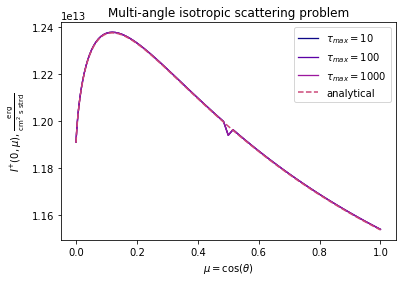

In [4]:
# parameters:
tau_max_arr = np.array([10., 100., 1000.])
Dn = 500  # number of points in spatial grid (tau)

Mn = 101  # number of angles
mi_0 = 50 # the number of the angle under wich atmosphere is illuminated: mu[50] = 0.5

Nn = 5
homegakev = np.logspace(-3., 0.5, Nn)
homega = homegakev * c.keverg

I_inc = 1e-3 # illulination (same for all frequencies)
kT_BB = 0    # it set I^{+} equal to zero
bottom = 0   # diffusion limit boundary condition (du/dtau = 0)

colors = plt.cm.plasma(np.linspace(0., 0.5, tau_max_arr.size+1))

# calculating the solution for the set of tau_max:
i = 0
for tau_max in tau_max_arr:
    tau_depth, mu, u =  fsl.radtransf(tau_max, Dn, Mn, mi_0, homega, I_inc*np.ones((Nn)), kT_BB, bottom)
    
    u0 = u[0]
    
    Iplus = np.zeros((Mn), dtype=np.float64)
    
    for mi in range(Mn):
        I_nu = np.zeros((Nn), dtype=np.float64)
        for ni in range(Nn):
            un = u0[ni]
            if (mi == mi_0):
                I_nu[ni] = 2. * un[mi] - I_inc
            else:
                I_nu[ni] = 2. * un[mi]
        Iplus[mi] = np.trapz(I_nu, homega / c.herg)
    plt.plot(mu, Iplus, color=colors[i], linewidth=1.3, label=r'$\tau_{max}= %d$'% tau_max_arr[i])
    i += 1

I_plus_analyt = chand_multiang(I_inc, homega, mu, mi_0)
plt.plot(mu, I_plus_analyt, color=colors[i], linestyle='--', label=r'analytical')
plt.title(r'Multi-angle isotropic scattering problem')
plt.xlabel(r"$\mu = \cos(\theta)$")
plt.ylabel(r"$I^{\plus}(0, \mu)$, $\frac{\mathrm{erg}}{\mathrm{cm}^{2} \ \mathrm{s} \ \mathrm{strd}}$")
plt.legend()
plt.show()


#### bottom boundary condition: ####
$$\mu\frac{du_{E, \tau=\tau_{\mathrm{max}},\mu}}{d\tau} = u_{E, \tau=\tau_{\mathrm{max}},\mu} - I^{+}_{E, \mu} \ , \ \ I^{+}_{E, \mu} = 0 \ .$$

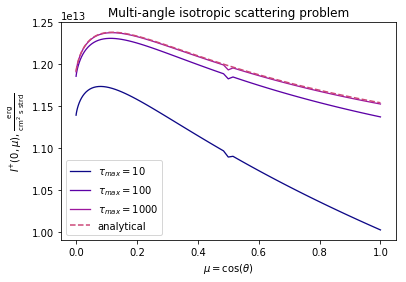

In [5]:
# boundary condition more appropriate for finite atmosphere
bottom = 1 # boundary condition with illumination
kT_BB = 0  # set I^{+} equal to zero

# calculating the solution for the set of tau_max:
i = 0
for tau_max in tau_max_arr:
    tau_depth, mu, u =  fsl.radtransf(tau_max, Dn, Mn, mi_0, homega, I_inc*np.ones((Nn)), kT_BB, bottom)
    
    u0 = u[0]
    
    Iplus = np.zeros((Mn), dtype=np.float64)
    
    for mi in range(Mn):
        I_nu = np.zeros((Nn), dtype=np.float64)
        for ni in range(Nn):
            un = u0[ni]
            if (mi == mi_0):
                I_nu[ni] = 2. * un[mi] - I_inc
            else:
                I_nu[ni] = 2. * un[mi]
        Iplus[mi] = np.trapz(I_nu, homega / c.herg)
    plt.plot(mu, Iplus, color=colors[i], linewidth=1.3, label=r'$\tau_{max}= %d$'% tau_max_arr[i])
    i += 1

    
I_plus_analyt = chand_multiang(I_inc, homega, mu, mi_0)
plt.plot(mu, I_plus_analyt, color=colors[i], linestyle='--', label=r'analytical')
plt.title(r'Multi-angle isotropic scattering problem')
plt.xlabel(r"$\mu = \cos(\theta)$")
plt.ylabel(r"$I^{\plus}(0, \mu)$, $\frac{\mathrm{erg}}{\mathrm{cm}^{2} \ \mathrm{s} \ \mathrm{strd}}$")
plt.legend()
plt.show()


# Relativistic Compton energy redistribution for pure scattering atmosphere

Now we assume that photons change their energy due to scattering process. The source function for pure scattering isotropic atmosphere now is represented by the double integral:

$$S_{\mathrm{E}} = \int_{E_{\mathrm{min}}}^{E_{\mathrm{max}}} dE^{'}\int_{-1}^{1} d\mu^{'} R(E, E^{'})  \ I_{\mathrm{E^{'}}, \mathrm{\mu^{'}}} \ ,$$

where $R(E, E^{'})$ if the redistribution function which describes the probability for the photon with initial energy $E$ to gain energy $E^{'}$ after single scattering process. Read the *'Compton scattering redistribution function'* notebook for more detailed discussion.

As for the one-angle task without frequency redistribution, we consider the slab-like pure scattering atmosphere, illuminated with infalling radiation under some angle $\mu_{0}$ and with the seed black-body photons from the bottom of the slab.

<b> Note (Katya):</b> It seems that having the angle-dependent task without energy redistribution I can apply the efficient algorithm with 'dismembered' matrices (usual size of matrices for each depth point is $I \times I, \ I = N \times M$, where $N$, $M$ - number of points in energy and angular grid, respectively) when all operations are performed on block-diagonal matrices and only block-diagonal parts are stored in memory. The size of  each block in this case is $M \times M$. The source function in this case is simply $S_{\mathrm{E}} = \int_{-1}^{1}I_{\mathrm{E^{'}}, \mathrm{\mu^{'}}} d\mu^{'}$. I've though that I could apply the same approach for isotropic atmosphere with energy-redistribution, having block-diagonal matrices with blocks of the size $N \times N$, but it doesn't look correct due to the fact that integral over angle presents in the source function even in isotropic task to obtain the intensity moment $J$.


<b> Note (Katya):</b> LU decomposition now is used instead of inversion in my routines. For numpy implementation it gives only 
$10-20 \%$ gain in speed but obviously more stable.

### Solution by Sokolova-Lapa's routines:

The compton redistribution function which is used for current task is the exact quantum mechanical formula for fully relativistic scattering process (Nagirner & Poutanen 1993), integrated over the electron Lorenz factor with Maxwell-Juenter distribution function and later integrated over scattering angle using the Gauss-Legandre quadrature.  

In [5]:
# calculating the solution for slabs with the different electron temperature:

Nn = 500
Mn = 2
Dn = 100

tau_max = 10.
kT_arr = np.array([2., 6., 10.]) * c.keverg
ne = 1e+22 # electron density doesn't matter as lond as absorption is not included

homega = np.logspace(-4., 3., Nn) * c.keverg

# angle for power-law irradiation:
mi_0 = 0
# temperature of BB seed photons:
kt_BB = 0.35 * c.keverg
I_bb = bbint(homega, kt_BB)
I_inc = powint(2, homega, I_bb)

eq = 0   # no induced processes are taken into account
nabs = 0 # free-free absorption is not taken inot account

I_plus_list = []
for i in range(0, 3):
    kT = kT_arr[i]
    I_plus = fr.rt_ered(tau_max, homega, Mn, mi_0, I_inc, Dn, kT, ne, I_bb, eq, nabs)
    I_plus_list.append(I_plus[0])
    print(kT)    

3.2043532416e-09
9.6130597248e-09
1.6021766208e-08


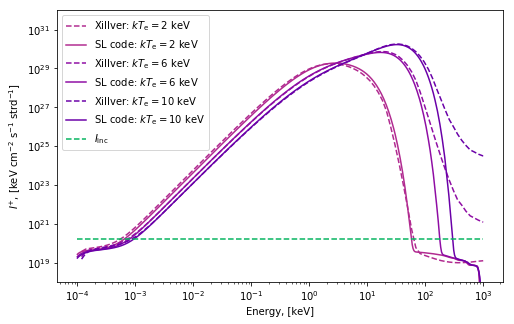

In [7]:
matplotlib.rcParams['figure.figsize'] = (8, 5)

kTkev = np.array([2., 6., 10.])

homega = np.logspace(-4., 3., 500) * c.keverg
tau_max = 10.
kt_BB = 0.35 * c.keverg
I_bb = bbint(homega, kt_BB)
I_inc = powint(2, homega, I_bb)

colors = plt.cm.plasma(np.linspace(0., 0.7, len(kTkev)+5))

folder = './sl_output_red/'

for i in range(kTkev.size):
    
    xill_path='./xillver_outputs_freq-redist/kTe_%d'%kTkev[i] + '/'
    xill_flux = ascii.read(xill_path+'spectr')
    ener = np.array(xill_flux[0][:]/1.e3)
    flux = np.array(xill_flux[1][:])
    ergsev = 1.602197e-12
    plt.loglog(ener, flux*ener, color=colors[4-i], linestyle='--', label=r'Xillver: $kT_{\mathrm{e}} =%.d $' % kTkev[i] + ' keV')
    
    fname = folder+'spectra_tau_%.2f_te_%.2f' % (tau_max, kTkev[i])+'.fits'
    with pyfits.open(fname) as hdul:
        cols = hdul[1].columns
        data = hdul[1].data
        homegakev = data.field(0)
        #for mi in range(1, len(cols.names)):
        Iplus_mu = data.field(1)
        plt.loglog(homegakev, Iplus_mu/c.hkev*c.ergkev*homegakev, color=colors[4-i], label=r'SL code: $kT_{\mathrm{e}} = %.d$' % kTkev[i] + ' keV')

#plt.loglog(homegakev, I_bb/c.hkev*c.ergkev*homegakev, color='#240B3B', label=r'$I_{\mathrm{bb}}$')
plt.loglog(homegakev, I_inc/c.hkev*c.ergkev*homegakev, color='#04B45F', linestyle='--', label=r'$I_{\mathrm{inc}}$')
plt.xlabel(r'Energy, [keV]')  
plt.ylabel(r'$I^{+}$, [keV cm$^{-2}$ s$^{-1}$ strd$^{-1}$]')
plt.legend(loc = 'upper left')
plt.ylim(1e+18, 1e+32)

#plt.savefig('freq-red_comp.pdf', dpi=300)

plt.show()

# Comparison with compTT model by Titarchuk

The model *compTT* calculates the comptonization of the soft photons in the hot plasma using analytical approximation for fully relativistic case. There are two possible geometries: spherical and disk one. The seed soft photons are distributed according to Wien's law. 
We use this model to check the comptonization of the spectrum calculated by Feautrier method.

We assume the same parameters of the task which are applied for *compTT* model: pure scattering atmosphere, no infalling flux ($I^{+}_{\tau=0}=0)$, seed photons are given by Wien distribution law.

There are plots for comparison if the comptt and feautrier (SL) output below. Left column is calculated for different electron temperature with fixed $\tau_{\mathrm{max}}=10$, right column - for different $\tau$ with fixed $kT_{\mathrm{e}}=8$ keV. 
The *compTT* model includes the free parameter 'norm' which is equal to 1 by default. To adjust the plots the compTT spectrum has to be multyplied by appropriate constant. Though apparently (it is seen even better from comparison for different seed photons temperature ($kT_{\mathrm{bb}}$) below) this parameter is different for different parameters of the model. 

<b>Note (Katya):</b> Though I don't really like the fact that depending on which parts of the spectra I'm trying to adjust (low energy or high energy) deviations of the spectra looks quite different.
    
The equilibrium spectrum for the pure scattering atmosphere of temperature $T_{e}$ (Wien spectrum $I_{\mathrm{wien}}(T_{\mathrm{e}})$) is also plotted.

In [ ]:
# Comparison with comptt (Titarchuk model):
# FOR DIFFERENT ELECTRON TEMPERATURE

Nn = 200
Mn = 1
Dn = 200

tau_max = 10.
kT_arr = np.array([2., 4., 7., 15.]) * c.keverg
ne = 1e+22 # electron density doesn't matter as lond as absorption is not included

homega = np.logspace(-3., 3., Nn) * c.keverg

# angle for power-law irradiation:
mi_0 = 0
# temperature of the seed photons:
kt_BB = 0.35 * c.keverg
I_wien = 2. * homega**3 / (c.herg*c.cl)**2 * np.exp(-homega/kt_BB)
I_inc = np.zeros((Nn))

eq = 0   # no induced processes are taken into account
nabs = 0 # free-free absorption is not taken inot account

I_plus_list = []
for i in range(0, 4):
    kT = kT_arr[i]
    I_plus = fr.rt_ered(tau_max, homega, Mn, mi_0, I_inc, Dn, kT, ne, I_wien, eq, nabs)
    I_plus_list.append(I_plus[0])
    print(kT)    

In [ ]:
# Comparison with comptt (Titarchuk model):
# FOR DIFFERENT OPTICAL DEPTH

tau_max_arr = np.array([1., 5., 10., 50.])
kT = 8. * c.keverg

I_plus_list = []
for i in range(1, 4):
    tau_max = tau_max_arr[i]
    I_plus = fr.rt_ered(tau_max, homega, Mn, mi_0, I_inc, Dn, kT, ne, I_wien, eq, nabs)
    I_plus_list.append(I_plus[0])
    print(tau_max)   

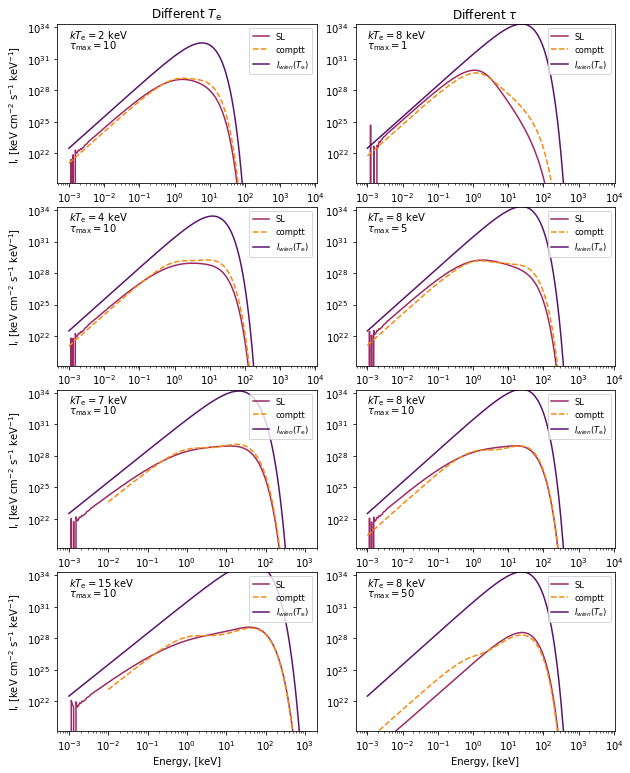

In [49]:
# Plot the spectra for different temperature and different optical depth:

matplotlib.rcParams['figure.figsize'] = (10, 13)

colors = plt.cm.inferno(np.linspace(0.1, 0.9, 6))

fig2, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8)) = plt.subplots(nrows=4, ncols=2, gridspec_kw={'wspace': 0.15, 'hspace': 0.15}) 
ax = [ax1, ax3, ax5, ax7, ax2, ax4, ax6, ax8]

kTkev = np.array([2., 4., 7., 15., 8., 8., 8., 8.])
tau = np.array([10., 10., 10., 10., 1., 5., 10., 50.])

# normalization for comptt spectra to adjust the curves:
norm = np.array([2e+29, 1.5e+29, 5e+28, 1.5e+28, 1e+29, 6e+28, 3e+28, 4e+27])
# if we assume that the norm is the same for all cases:
#norm = 1.5e+29 * np.ones((8))

for i in range(8):
    fname = './sl_output_red/comptt/spectra_tau_%.2f_te_%.2f' % (tau[i], kTkev[i])+'.fits'
    with pyfits.open(fname) as hdul:
        cols = hdul[1].columns
        data = hdul[1].data
        homegakev = data.field(0)
        Iplus_mu = data.field(1)
    ax[i].loglog(homegakev, Iplus_mu / c.hkev * c.ergkev, color=colors[2], linestyle='-', label=r'SL')

    table_comptt = "./comptt_output/comptt_tau_%.2f_te_%.2f" % (tau[i], kTkev[i]) + ".dat"
    data = ascii.read(table_comptt)
    e_comptt = np.array(data['col1'])
    flux_comptt = np.array(data['col2'])
    #norm = 1.5e+29
    ax[i].loglog(e_comptt, flux_comptt*norm[i], linestyle='--', color=colors[4], label=r'comptt')
    
    wien_te = 2. * homega**3 / (c.herg*c.cl)**2 * np.exp(-homega/(kTkev[i]*c.keverg))
    ax[i].loglog(homega*c.ergkev, wien_te / c.hkev * c.ergkev, color=colors[1], linestyle='-', label=r'$I_{wien}(T_{\mathrm{e}})$')
    
    ax[i].set_ylim(1.5e+19, 2e+34)
    ax[i].legend(loc='upper right', fontsize='small')
    ax[i].text(1e-3, 1e+33, r'$kT_{\mathrm{e}} = %.0f$' % kTkev[i] + ' keV')
    ax[i].text(1e-3, 1e+32, r'$\tau_{\mathrm{max}} = %.0f$' % tau[i])

ax[0].set_title(r'Different $T_{\mathrm{e}}$')
ax[4].set_title(r'Different $\tau$')
ax[3].set_xlabel(r'Energy, [keV]')
ax[7].set_xlabel(r'Energy, [keV]')

for i in range(0, 4):
    ax[i].set_ylabel(r'I, [keV cm$^{-2}$ s$^{-1}$ keV$^{-1}$]')
    
plt.show()


<b>Note(Katya):</b> Obviously, there are the differences in the shape of the spectrum, for now I have no idea what is the reason. For me it looks like the 'footprint' of the seed spectrum is more pronounced in the *compTT* spectrum. 
To get some clues, I calculated the same for the different temperature of the seed photons.

In [ ]:
# Comparison with comptt (Titarchuk model):
# SEED PHOTONS TEMPERATURE
 
Nn = 150
Mn = 1
Dn = 200

tau_max = 10.
kT = 7. * c.keverg
ne = 1e+22 # electron density doesn't matter as lond as absorption is not included

homega = np.logspace(-3., 3., Nn) * c.keverg

# angle for power-law irradiation:
mi_0 = 0
# temperature of the seed photons:
kt_BB_arr = np.array([0.1, 0.5, 1.1, 5.]) * c.keverg
#I_wien = 2. * homega**3 / (c.herg*c.cl)**2 * np.exp(-homega/kt_BB)
I_inc = np.zeros((Nn))

eq = 0   # no induced processes are taken into account
nabs = 0 # free-free absorption is not taken inot account

I_plus_list = []
for i in range(0, 5):
    kT_BB = kt_BB_arr[i]
    I_wien = 2. * homega**3 / (c.herg*c.cl)**2 * np.exp(-homega/kT_BB)
    I_plus = fr.rt_ered(tau_max, homega, Mn, mi_0, I_inc, Dn, kT, ne, I_wien, eq, nabs)
    I_plus_list.append(I_plus[0])
    #plt.loglog(homega*c.ergkev, I_wien)
    #print(kT_BB)

#plt.ylim(1e-10, 1e+10)
#plt.show()

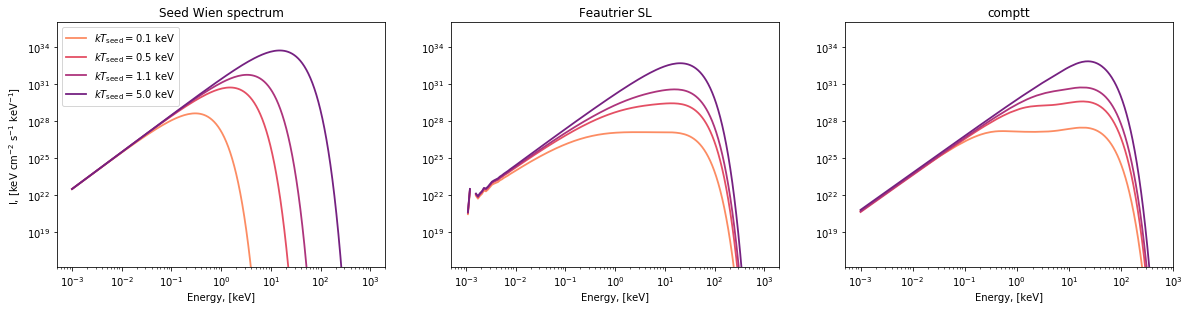

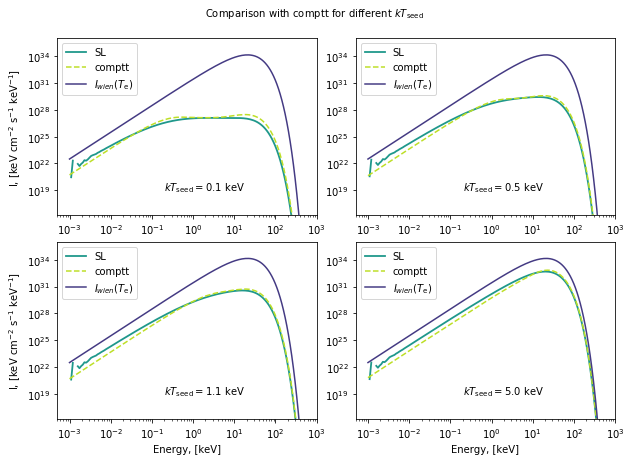

In [37]:
matplotlib.rcParams['figure.figsize'] = (20, 4.5)

fig, ((ax1, ax2, ax3)) = plt.subplots(nrows=1, ncols=3, gridspec_kw={'wspace': 0.2, 'hspace': 0.3})

colors = plt.cm.magma(np.linspace(0.9, 0.2, 6))

kT_wien = np.array([0.1, 0.5, 1.1, 5.])
homega = np.logspace(-3., 3., Nn) * c.keverg

folder = './sl_output_red/comptt/'

norm = np.array([0.1e+2, 0.1e+4, 1.2e+4, 0.15e+7]) * 1.51e+26

for i in range(4):
    I_wien = 2. * homega**3 / (c.herg*c.cl)**2 * np.exp(-homega/(kT_wien[i]*c.keverg))
    ax1.loglog(homega*c.ergkev, I_wien / c.hkev * c.ergkev, color=colors[i+1], linewidth='1.8', label=r'$kT_{\mathrm{seed}} = %.1f$' % kT_wien[i] + ' keV')
    ax1.set_ylim(1.5e+16, 1e+36)
    ax1.legend(loc='upper left')#, fontsize='small')
    ax1.set_title(r'Seed Wien spectrum')
    ax1.set_ylabel(r'I, [keV cm$^{-2}$ s$^{-1}$ keV$^{-1}$]')
    ax1.set_xlabel(r'Energy, [keV]')
   
    fname = folder + 'spectra_tau_%.2f_te_%.2f_bb%.2f' % (10., 7., kT_wien[i])+'.fits'
    with pyfits.open(fname) as hdul:
        cols = hdul[1].columns
        data = hdul[1].data
        homegakev = data.field(0)
        Iplus_mu = data.field(1)
    ax2.loglog(homegakev, Iplus_mu / c.hkev * c.ergkev, color=colors[i+1], linewidth='1.8', label=r'$kT_{\mathrm{seed}} = %.1f$' % kT_wien[i] + ' keV')
    ax2.set_ylim(1.5e+16, 1e+36)
    ax2.set_title(r'Feautrier SL')
    ax2.set_xlabel(r'Energy, [keV]')
    #ax2.legend(loc='upper left')#, fontsize='small')

    table_comptt = "./comptt_output/comptt_tau_%.2f_te_%.2f_bb%.2f" % (10., 7., kT_wien[i]) + ".dat"
    data = ascii.read(table_comptt)
    e_comptt = np.array(data['col1'])
    flux_comptt = np.array(data['col2'])
    ax3.loglog(e_comptt, flux_comptt*norm[i], color=colors[i+1], linewidth='1.8', label=r'$kT_{\mathrm{seed}} = %.1f$' % kT_wien[i] + ' keV')
    ax3.set_ylim(1.5e+16, 1e+36)
    ax3.set_xlim(0.5e-3, 1e+3)
    ax3.set_title(r'comptt')
    ax3.set_xlabel(r'Energy, [keV]')               
    #ax3.legend(loc='upper left')#, fontsize='small')

plt.show()


matplotlib.rcParams['figure.figsize'] = (10, 7)

fig2, ((ax12, ax22), (ax32, ax42)) = plt.subplots(nrows=2, ncols=2, gridspec_kw={'wspace': 0.15, 'hspace': 0.15}) 
ax = [ax12, ax22, ax32, ax42]

fig2.text(0.33, 0.93, r'Comparison with comptt for different $kT_{\mathrm{seed}}$', va='center')

colors = plt.cm.viridis(np.linspace(0.17, 0.9, 3))

for i in range(4):
    fname = folder + 'spectra_tau_%.2f_te_%.2f_bb%.2f' % (10., 7., kT_wien[i])+'.fits'
    with pyfits.open(fname) as hdul:
        cols = hdul[1].columns
        data = hdul[1].data
        homegakev = data.field(0)
        Iplus_mu = data.field(1)
    ax[i].loglog(homegakev, Iplus_mu / c.hkev * c.ergkev, color=colors[1], linewidth='1.8', label=r'SL')
    
    table_comptt = "./comptt_output/comptt_tau_%.2f_te_%.2f_bb%.2f" % (10., 7., kT_wien[i]) + ".dat"
    data = ascii.read(table_comptt)
    e_comptt = np.array(data['col1'])
    flux_comptt = np.array(data['col2'])
    #norm = 0.2e+6 # have no idea about normalization in comptt... so just shift it up/down
    ax[i].loglog(e_comptt, norm[i]*flux_comptt, color=colors[2], linestyle='--', label=r'comptt')
    
    wien_te = 2. * homega**3 / (c.herg*c.cl)**2 * np.exp(-homega/(7.*c.keverg))
    ax[i].loglog(homega*c.ergkev, wien_te / c.hkev * c.ergkev , color=colors[0], linestyle='-', label=r'$I_{wien}(T_{\mathrm{e}})$')
    
    ax[i].set_ylim(1.5e+16, 1e+36)
    ax[i].set_xlim(0.5e-3, 1e+3)
    
    ax[i].legend(loc='upper left')
    ax[i].text(0.2, 1e+19, r'$kT_{\mathrm{seed}}=%.1f$' % kT_wien[i] + ' keV')

ax[2].set_xlabel(r'Energy, [keV]') 
ax[3].set_xlabel(r'Energy, [keV]')     

ax[0].set_ylabel(r'I, [keV cm$^{-2}$ s$^{-1}$ keV$^{-1}$]')
ax[2].set_ylabel(r'I, [keV cm$^{-2}$ s$^{-1}$ keV$^{-1}$]')
    
    
plt.show()